# RNNs on a Time Series

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
df = pd.read_csv('PYTORCH_NOTEBOOKS/Data/TimeSeriesData/Alcohol_Sales.csv', index_col=0, parse_dates=True)

In [5]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [7]:
df = df.dropna()
len(df)

325

In [9]:
y = df['S4248SM144NCEN'].values.astype(float)

In [10]:
test_size = 12

In [11]:
train_set = y[:-test_size]
test_set = y[-test_size:]

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [21]:
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [22]:
test_norm = scaler.transform(test_set.reshape(-1, 1))

In [23]:
train_norm = torch.FloatTensor(train_norm).view(-1)

In [25]:
window_size = 12
def input_data(seq, window_size):
    out = []
    L = len(seq)
    for i in range(L-window_size):
        out.append((seq[i:i+window_size], seq[i+window_size:i+window_size+1]))
    
    return out

In [26]:
train_data = input_data(train_norm, window_size)

In [27]:
len(train_data)

301

In [30]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 100, output_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden = (torch.zeros(1,1,hidden_size), torch.zeros(1,1,hidden_size))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq), -1))
        return pred[-1]

In [31]:
torch.manual_seed(101)
model = LSTMNetwork()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [32]:
epochs = 100
import time
start_time = time.time()

for epoch in range(epochs):
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1} Loss {loss.item()}')

total_time = time.time() - start_time
print(total_time/60)

Epoch 1 Loss 0.2531020939350128
Epoch 2 Loss 0.3753201365470886
Epoch 3 Loss 0.390271931886673
Epoch 4 Loss 0.34934696555137634
Epoch 5 Loss 0.33085644245147705
Epoch 6 Loss 0.3322998285293579
Epoch 7 Loss 0.3267034888267517
Epoch 8 Loss 0.32074129581451416
Epoch 9 Loss 0.3065353333950043
Epoch 10 Loss 0.29518038034439087
Epoch 11 Loss 0.2693434953689575
Epoch 12 Loss 0.25998514890670776
Epoch 13 Loss 0.24665714800357819
Epoch 14 Loss 0.22403818368911743
Epoch 15 Loss 0.18602792918682098
Epoch 16 Loss 0.18561148643493652
Epoch 17 Loss 0.17209382355213165
Epoch 18 Loss 0.25162333250045776
Epoch 19 Loss 0.22557726502418518
Epoch 20 Loss 0.17450936138629913
Epoch 21 Loss 0.2023782581090927
Epoch 22 Loss 0.20813527703285217
Epoch 23 Loss 0.16641975939273834
Epoch 24 Loss 0.17605148255825043
Epoch 25 Loss 0.11976473033428192
Epoch 26 Loss 0.0964580550789833
Epoch 27 Loss 0.045710522681474686
Epoch 28 Loss 0.05649115517735481
Epoch 29 Loss 0.001215607626363635
Epoch 30 Loss 0.114146389067173

In [33]:
future = 12
preds = train_norm[-window_size:].tolist()
model.eval()
for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [34]:
preds[window_size:]

[0.24252602458000183,
 0.6267620921134949,
 0.43970999121665955,
 0.8351505994796753,
 1.0259838104248047,
 0.44212213158607483,
 0.7402645945549011,
 0.5118022561073303,
 0.6928802728652954,
 0.7601770162582397,
 0.8815797567367554,
 0.16979515552520752]

In [35]:
true_preds = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1,1))

In [36]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [37]:
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]')
x

array(['2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='datetime64[M]')

In [38]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=325, freq=None)

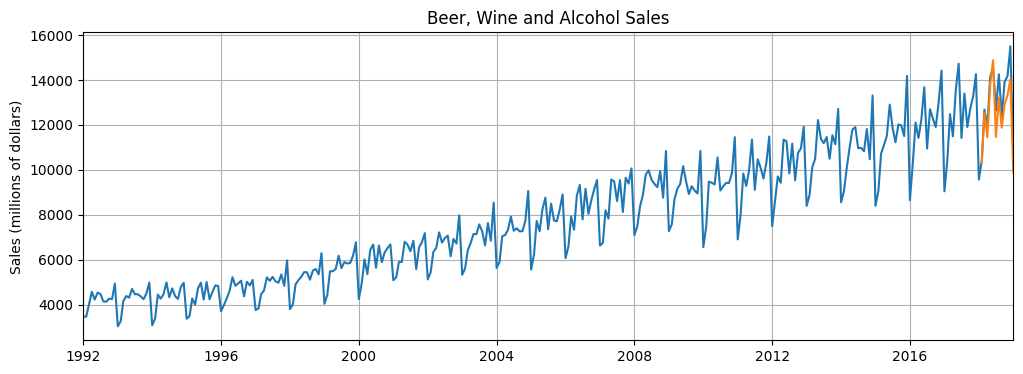

In [39]:
plt.figure(figsize=(12, 4))
plt.title('Beer, Wine and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis = 'x', tight = True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x, true_preds)
plt.show()

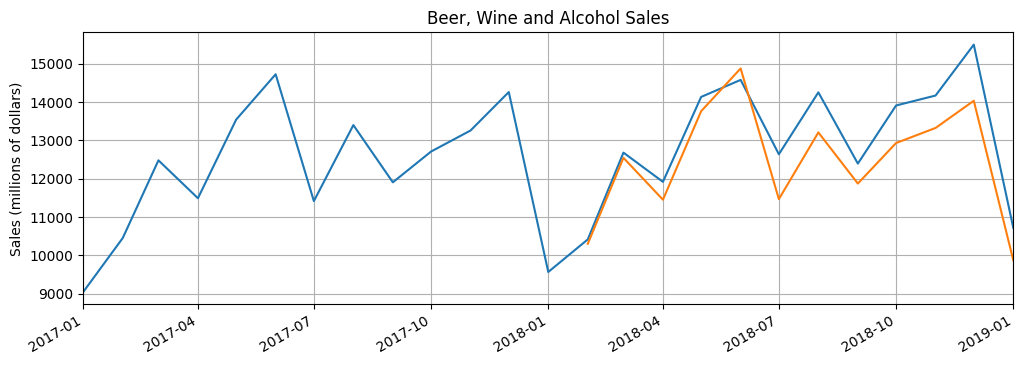

In [40]:
fig = plt.figure(figsize=(12, 4))
plt.title('Beer, Wine and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis = 'x', tight = True)
fig.autofmt_xdate()

plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x, true_preds)
plt.show()

In [41]:
epochs = 100
model.train()
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm, window_size)
import time
start_time = time.time()

for epoch in range(epochs):
    for seq, y_train in all_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        y_pred = model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch: {epoch+1:2} Loss: {loss.item(): 10.8f}')

total_time = time.time() - start_time
print(f'Duration: {total_time:.0f} seconds')

Epoch:  1 Loss:  0.01941586
Epoch:  2 Loss:  0.02900102
Epoch:  3 Loss:  0.01772452
Epoch:  4 Loss:  0.01616115
Epoch:  5 Loss:  0.01492068
Epoch:  6 Loss:  0.01446190
Epoch:  7 Loss:  0.01382533
Epoch:  8 Loss:  0.01423280
Epoch:  9 Loss:  0.01357602
Epoch: 10 Loss:  0.00958912
Epoch: 11 Loss:  0.00745150
Epoch: 12 Loss:  0.00601862
Epoch: 13 Loss:  0.00586351
Epoch: 14 Loss:  0.00466521
Epoch: 15 Loss:  0.00558394
Epoch: 16 Loss:  0.00504329
Epoch: 17 Loss:  0.00607216
Epoch: 18 Loss:  0.00223212
Epoch: 19 Loss:  0.00506671
Epoch: 20 Loss:  0.00544172
Epoch: 21 Loss:  0.00647368
Epoch: 22 Loss:  0.00358336
Epoch: 23 Loss:  0.00321669
Epoch: 24 Loss:  0.00202412
Epoch: 25 Loss:  0.00218441
Epoch: 26 Loss:  0.00698097
Epoch: 27 Loss:  0.00115116
Epoch: 28 Loss:  0.00143223
Epoch: 29 Loss:  0.00110073
Epoch: 30 Loss:  0.00061020
Epoch: 31 Loss:  0.00074808
Epoch: 32 Loss:  0.00154954
Epoch: 33 Loss:  0.00008056
Epoch: 34 Loss:  0.00119266
Epoch: 35 Loss:  0.00378208
Epoch: 36 Loss:  0.0

In [42]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()
model.eval()
for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size), torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [43]:
true_preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

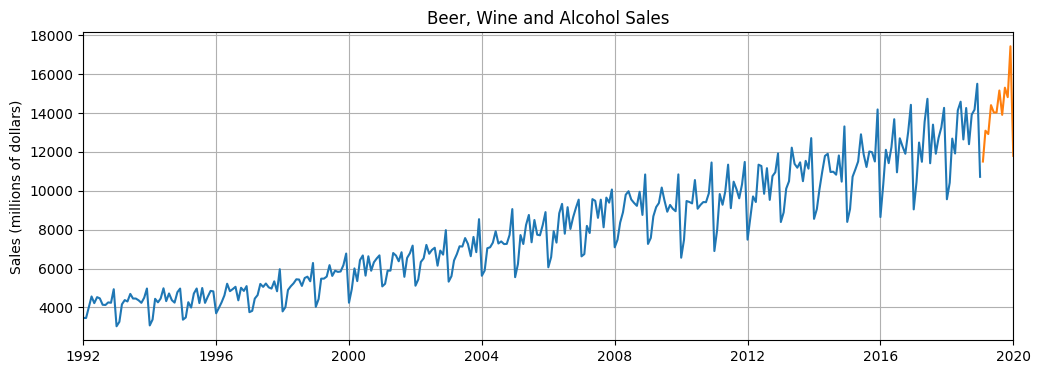

In [46]:
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[ns]')
plt.figure(figsize=(12, 4))
plt.title('Beer, Wine and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis = 'x', tight = True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x, true_preds[-window_size:])
plt.show()